### 1. Upload modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import base64

In [3]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from io import BytesIO

from mordred import Calculator, descriptors 

### 2. Data

In [5]:
df_IDO1 = pd.read_csv('data_IDO1.csv')
df_IDO1

,ID,SMILES,pIC50,uM
0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000
1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000
2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400
3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200
4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100
...,...,...,...,...
871,871,C[S@@](=N)(=O)CCNC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,7.055024,0.0881
872,872,C1[C@@H](C2=C1C=CC(=C2)F)N=C(C3=NON=C3NC4CS(=N...,7.042872,0.0906
873,873,C1[C@@H](C2=C1C=CC(=C2)F)N=C(C3=NON=C3NCC4CS(=...,7.292430,0.0510
874,874,C[S@](=N)(=O)CCCOC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,6.671620,0.2130


### 3. Data preprocessing

##### 4.1. Remove duplicate from SMILES

In [6]:
#Change all SMILES in dataframe into 1 type of SMILES - canonical SMILES
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

canon_SMILES = canonical_smiles(df_IDO1.SMILES)
df_IDO1['canon_SMILES'] = canon_SMILES
df_IDO1

,ID,SMILES,pIC50,uM,canon_SMILES
0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000,COC1=C(OC)C(=O)C(CC=C(C)C)=C(C)C1=O
1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000,COC1=C(OC)C(=O)C(CCC(C)C)=C(C)C1=O
2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400,COC1=C(OC)C(=O)C(CCc2ccccc2)=C(C)C1=O
3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200,COC1=C(OC)C(=O)C(CCC2CCCCC2)=C(C)C1=O
4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100,COC1=C(OC)C(=O)C(Cc2ccccc2)=C(C)C1=O
...,...,...,...,...,...
871,871,C[S@@](=N)(=O)CCNC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,7.055024,0.0881,C[S@@](=N)(=O)CCNc1nonc1C(=N[C@H]1Cc2ccc(F)cc2...
872,872,C1[C@@H](C2=C1C=CC(=C2)F)N=C(C3=NON=C3NC4CS(=N...,7.042872,0.0906,N=S1(=O)CC(Nc2nonc2C(=N[C@H]2Cc3ccc(F)cc32)NO)C1
873,873,C1[C@@H](C2=C1C=CC(=C2)F)N=C(C3=NON=C3NCC4CS(=...,7.292430,0.0510,N=S1(=O)CC(CNc2nonc2C(=N[C@H]2Cc3ccc(F)cc32)NO)C1
874,874,C[S@](=N)(=O)CCCOC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,6.671620,0.2130,C[S@](=N)(=O)CCCOc1nonc1C(=N[C@H]1Cc2ccc(F)cc2...


In [11]:
df_IDO1_1 = df_IDO1.drop_duplicates('canon_SMILES')
df_IDO1_1

,ID,SMILES,pIC50,uM,canon_SMILES
0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000,COC1=C(OC)C(=O)C(CC=C(C)C)=C(C)C1=O
1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000,COC1=C(OC)C(=O)C(CCC(C)C)=C(C)C1=O
2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400,COC1=C(OC)C(=O)C(CCc2ccccc2)=C(C)C1=O
3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200,COC1=C(OC)C(=O)C(CCC2CCCCC2)=C(C)C1=O
4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100,COC1=C(OC)C(=O)C(Cc2ccccc2)=C(C)C1=O
...,...,...,...,...,...
868,868,CS(=N)(=O)CCNC1=NON=C1C(=N[C@@H]2CC3=C2C(=CC=C...,6.958607,0.1100,CS(=N)(=O)CCNc1nonc1C(=N[C@@H]1Cc2cccc(F)c21)NO
870,870,CON=[S@@](=O)(C)CCNC1=NON=C1C(=N[C@H]2CC3=C2C=...,7.347754,0.0449,CON=[S@](C)(=O)CCNc1nonc1C(=N[C@H]1Cc2ccc(F)cc...
871,871,C[S@@](=N)(=O)CCNC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,7.055024,0.0881,C[S@@](=N)(=O)CCNc1nonc1C(=N[C@H]1Cc2ccc(F)cc2...
874,874,C[S@](=N)(=O)CCCOC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,6.671620,0.2130,C[S@](=N)(=O)CCCOc1nonc1C(=N[C@H]1Cc2ccc(F)cc2...


In [14]:
df_IDO1_2 = df_IDO1_1.reset_index()
df_IDO1_2

,index,ID,SMILES,pIC50,uM,canon_SMILES
0,0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000,COC1=C(OC)C(=O)C(CC=C(C)C)=C(C)C1=O
1,1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000,COC1=C(OC)C(=O)C(CCC(C)C)=C(C)C1=O
2,2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400,COC1=C(OC)C(=O)C(CCc2ccccc2)=C(C)C1=O
3,3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200,COC1=C(OC)C(=O)C(CCC2CCCCC2)=C(C)C1=O
4,4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100,COC1=C(OC)C(=O)C(Cc2ccccc2)=C(C)C1=O
...,...,...,...,...,...,...
820,868,868,CS(=N)(=O)CCNC1=NON=C1C(=N[C@@H]2CC3=C2C(=CC=C...,6.958607,0.1100,CS(=N)(=O)CCNc1nonc1C(=N[C@@H]1Cc2cccc(F)c21)NO
821,870,870,CON=[S@@](=O)(C)CCNC1=NON=C1C(=N[C@H]2CC3=C2C=...,7.347754,0.0449,CON=[S@](C)(=O)CCNc1nonc1C(=N[C@H]1Cc2ccc(F)cc...
822,871,871,C[S@@](=N)(=O)CCNC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,7.055024,0.0881,C[S@@](=N)(=O)CCNc1nonc1C(=N[C@H]1Cc2ccc(F)cc2...
823,874,874,C[S@](=N)(=O)CCCOC1=NON=C1C(=N[C@H]2CC3=C2C=C(...,6.671620,0.2130,C[S@](=N)(=O)CCCOc1nonc1C(=N[C@H]1Cc2ccc(F)cc2...


###### Note: The SMILES after dropping duplicates in "canon_SMILES" still contain chiral molecules 

##### 3.2. Eliminate chiral molecules

###### Use the Tanimoto coefficient to evaluate the structural similarity between two compounds based on fingerprints

In [16]:
# A. Generate a function to calculate Morgan fingerprint
for index, row in df_IDO1_2.iterrows():
    smiles = row['canon_SMILES']
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    df_IDO1_2.at[index, 'fp'] = fp

[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerator
[11:55:04] DEPRECATION WARNING: please use MorganGenerat

In [17]:
# B. Generate a function to calculate Tanimoto coefficient
def calc_tanimoto(fp1, fp2):
    tc = DataStructs.TanimotoSimilarity(fp1, fp2)
    return round(tc,2)

In [19]:
# Generate a Matrix of the difference between two canon_SMILES based on fingerprint
y = df_IDO1_2['fp']
Y = pd.DataFrame(y)
x = df_IDO1_2['fp']
X = pd.DataFrame(x)

matrix = np.zeros((len(X), len(Y)))

for i, row_x in X.iterrows():
    smiles_x = row_x['fp']
    for j, row_y in Y.iterrows():
        smiles_y = row_y['fp']
        coefficient = calc_tanimoto(smiles_x, smiles_y)
        matrix[i, j] = coefficient

matrixx = pd.DataFrame(matrix)

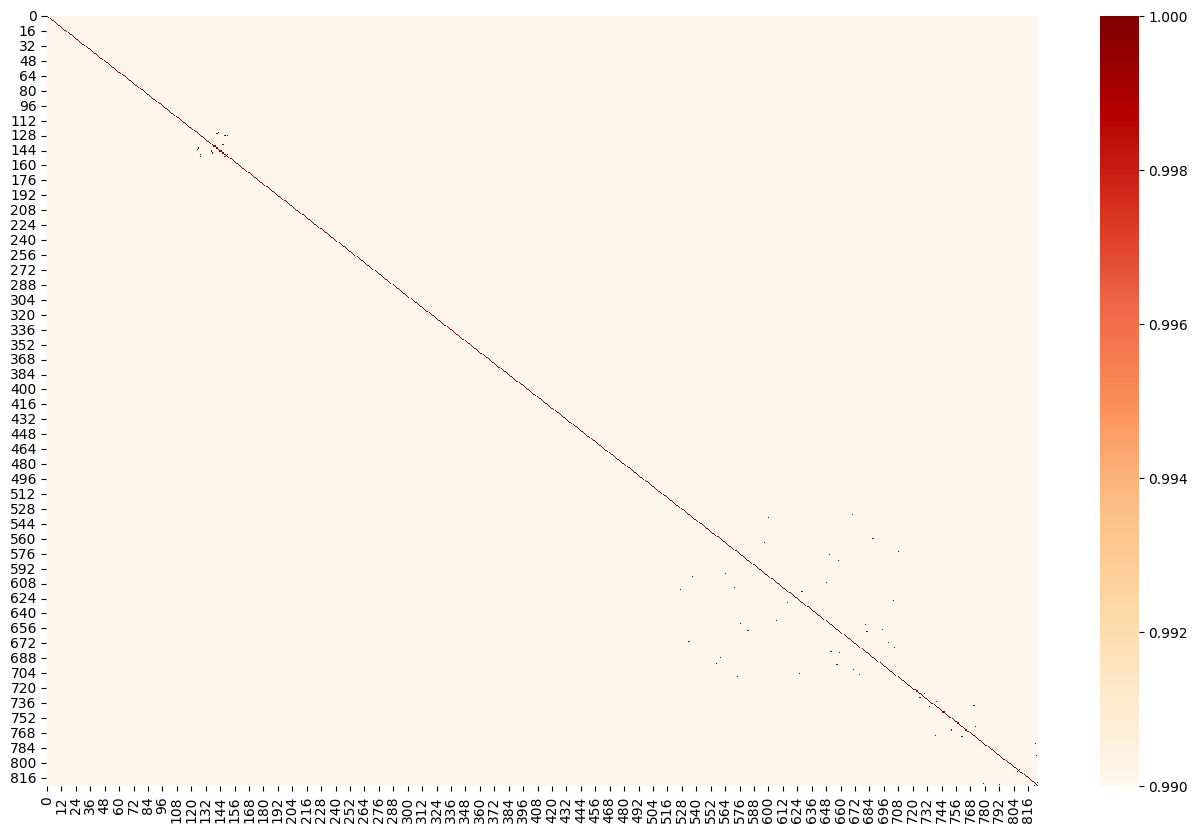

In [21]:
plt.figure(figsize= (16,10))
sns.heatmap(matrixx, cmap = "OrRd", vmin= 0.99, vmax = 1)
plt.show()

In [22]:
# Drop chiral SMILES
index_to_drop = []

for i in range(0, matrixx.shape[1]):
    if any(matrixx[matrixx.iloc[:,i]==1].count() >1):
        index_to_drop.append(i)
print(index_to_drop)
print(len(index_to_drop))

[125, 126, 128, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 527, 534, 537, 557, 560, 564, 572, 574, 577, 583, 597, 600, 607, 612, 614, 616, 626, 628, 648, 651, 652, 657, 658, 659, 670, 671, 676, 681, 682, 687, 694, 695, 700, 704, 705, 708, 721, 722, 723, 724, 726, 730, 734, 739, 740, 745, 746, 752, 757, 758, 761, 764, 765, 771, 772, 779, 792, 807, 809, 821, 822, 823, 824]
79


In [24]:
df_IDO1_3 = df_IDO1_2.drop(index = index_to_drop)
df_IDO1_3

,index,ID,SMILES,pIC50,uM,canon_SMILES,fp
0,0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000,COC1=C(OC)C(=O)C(CC=C(C)C)=C(C)C1=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000,COC1=C(OC)C(=O)C(CCC(C)C)=C(C)C1=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400,COC1=C(OC)C(=O)C(CCc2ccccc2)=C(C)C1=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200,COC1=C(OC)C(=O)C(CCC2CCCCC2)=C(C)C1=O,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100,COC1=C(OC)C(=O)C(Cc2ccccc2)=C(C)C1=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
816,856,856,CS(=N)(=O)N1CC2(C1)CC(C2)NC3=NON=C3C(=N[C@@H]4...,7.397940,0.0400,CS(=N)(=O)N1CC2(CC(Nc3nonc3C(=N[C@@H]3Cc4ccc(F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
817,858,858,CS(=N)(=O)CCC(CNC1=NON=C1C(=N[C@@H]2CC3=C2C=C(...,7.238072,0.0578,CS(=N)(=O)CCC(O)CNc1nonc1C(=N[C@@H]1Cc2ccc(F)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
818,862,862,CS(=N)(=O)CC12CC(C1)(C2)NC3=NON=C3C(=N[C@@H]4C...,7.037631,0.0917,CS(=N)(=O)CC12CC(Nc3nonc3C(=N[C@@H]3Cc4ccc(F)c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
819,864,864,CC(CS(=N)(=O)CCNC1=NON=C1C(=N[C@@H]2CC3=C2C=C(...,7.245652,0.0568,CC(O)CS(=N)(=O)CCNc1nonc1C(=N[C@@H]1Cc2ccc(F)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
df_IDO1_4 = df_IDO1_3.drop(['index', 'fp'], axis=1)
df_IDO1_5 = df_IDO1_4.reset_index()
df_IDO1_clear = df_IDO1_5.drop('index', axis = 1)

In [34]:
# Data
df_IDO1_clear

,ID,SMILES,pIC50,uM,canon_SMILES
0,0,COC(C1=O)=C(OC)C(C(C/C=C(C)\C)=C1C)=O,5.886057,1.3000,COC1=C(OC)C(=O)C(CC=C(C)C)=C(C)C1=O
1,1,COC(C1=O)=C(OC)C(C(CCC(C)C)=C1C)=O,5.552842,2.8000,COC1=C(OC)C(=O)C(CCC(C)C)=C(C)C1=O
2,2,COC(C1=O)=C(OC)C(C(CCC2=CC=CC=C2)=C1C)=O,5.450997,3.5400,COC1=C(OC)C(=O)C(CCc2ccccc2)=C(C)C1=O
3,3,COC(C1=O)=C(OC)C(C(CCC2CCCCC2)=C1C)=O,5.344862,4.5200,COC1=C(OC)C(=O)C(CCC2CCCCC2)=C(C)C1=O
4,4,COC(C1=O)=C(OC)C(C(CC2=CC=CC=C2)=C1C)=O,5.291579,5.1100,COC1=C(OC)C(=O)C(Cc2ccccc2)=C(C)C1=O
...,...,...,...,...,...
741,856,CS(=N)(=O)N1CC2(C1)CC(C2)NC3=NON=C3C(=N[C@@H]4...,7.397940,0.0400,CS(=N)(=O)N1CC2(CC(Nc3nonc3C(=N[C@@H]3Cc4ccc(F...
742,858,CS(=N)(=O)CCC(CNC1=NON=C1C(=N[C@@H]2CC3=C2C=C(...,7.238072,0.0578,CS(=N)(=O)CCC(O)CNc1nonc1C(=N[C@@H]1Cc2ccc(F)c...
743,862,CS(=N)(=O)CC12CC(C1)(C2)NC3=NON=C3C(=N[C@@H]4C...,7.037631,0.0917,CS(=N)(=O)CC12CC(Nc3nonc3C(=N[C@@H]3Cc4ccc(F)c...
744,864,CC(CS(=N)(=O)CCNC1=NON=C1C(=N[C@@H]2CC3=C2C=C(...,7.245652,0.0568,CC(O)CS(=N)(=O)CCNc1nonc1C(=N[C@@H]1Cc2ccc(F)c...


In [35]:
df_IDO1_clear.to_csv('df_IDO1_clear.csv')